# Trigger Level Analysis Plotting for Response and Resolution studies at the ATLAS Experiment

## Abstract
The Trigger Level Analysis (TLA) at the ATLAS experiment uses partly reconstructed particle collision events for its analysis. The smaller data size allows TLA to obtain a much larger number of events and a smaller statisitical uncertainty. This notebook presents the data processing and analysis used to verify the smoothness of the TLA calibration as well as the resolution of the analysis.

## Introduction
When particles collide at the LHC it is possible that new particles are created which decay into decay products. The ATLAS detecor allows us to study the properties of these decay products and learn about the properties of the original particle. Due to the nature of the strong force, the proton-proton collisions at the LHC often one of the most commonly occurring observable objects at ATLAS are the collimated particle showers. From the detector data we can then group the energy deposits of these particle showers into an object called a jet, and by studying these jets we can learn about potential particles created in the collision.

Particle collision event data at the Large Hadron Collider (LHC) at CERN uses a specialized data framework and file format called ROOT. For each particle collision event we can acces, among other things, the jets energy and momentum (and direction in the cylindrical coordinates eta and phi). With this we can represent the two "largest" jets (highest transverse momentum (pT)) as Lorentz vectors and calculate the invariant mass of the particle formed by the collision (if there is any).

Before we run the following code a C++ algorithm has processed millions of simulated particle collision events. With simulated events we can look at the energy and momentum of particles and jets as they would look purley theoretically, called "truth jets". We can also simulate each particles propagation and interaction with the different elements of the detector, as well as the detecotr readout to get a so called "reconstructed jet". Looking at the ratio the transverse momentum, energy, or invariant mass between the reconstructed jets and truth jets can give us important information about our detector and data processing.

The C++ algorithm outputs 3D histograms with response, truth mjj (pT, or energy), truth eta on the x, y, and z axis respectively. This notebook transforms this 3D histogram and transforms it into more understandable plots such as response vs truth mjj using the following steps:

* Fitting
    * 3D histograms are sliced on the z axis and projected into a 2D histogram (each slice is usuallly a truht eta)
    * 2D histograms are sliced in bins on the y axis and projected into 1D histograms (each slice is usuallly a truht pT or truth mjj range/bin width)
    * 1D histograms are fitted with a gaussian using an external python script called "JESBalanceFitter"
    * Information about the gaussian fits are written to disk for future processing
* Plotting
    * A set of the avaliable fit collections is created, one per initial 3D histogram
    * For each 3D histogram the fit mean is plotted at the corresponding 1D histograms pT or mjj bin. Providing a response vs truth mjj plot for all bins

## Loading the 3D histograms


In [1]:
import ROOT
from array import array
from JES_BalanceFitter import JES_BalanceFitter
import numpy as np
import pandas as pd
import pickle

Welcome to JupyROOT 6.20/00


Initialise parameters for fitting

In [2]:
listOfRootFilePaths = ["/home/pekman/TLA/TH3Files/v14/merged_mc16d_mjj_v14.root",
                       "/home/pekman/TLA/TH3Files/v15/merged_mc16d_mjj_v15.root",
                       "/home/pekman/TLA/TH3Files/v18/merged_mc16a_mjj_v18.root",
                       "/home/pekman/TLA/TH3Files/v19/merged_mc16a_mjj_v19.root",
                      ]

graphType = "response"

slicingAxis = "z"
slices = [[-2.8,2.8],[-0.6,0.6]]

projectionAxis = "y"
projectionRebinWidth = 1

responseAxis = "x"

nSigmaForFit = 1.3
fitOptString = "RESQ"

Create an empty dataframe with an entry for each 3D histogram

In [3]:
for rootFilePath in listOfRootFilePaths:
    for currentSlice in slices:
        inFile = ROOT.TFile.Open(rootFilePath)
        listOfKeys = inFile.GetListOfKeys()

        l=[]
        for key in listOfKeys:
            TH3Name = key.GetName()
            if TH3Name[0:9] != "scaled_h_":
                continue
            elif inFile.Get(TH3Name).GetEntries()==0.0:
                print("WARNING:",TH3Name," is empty!")
                continue
            else:
                l.append(pd.Series({ "x"             :[],
                                     "y"             :[],
                                     "xError"        :[],
                                     "yError"        :[],
                                     "sigma"         :[],
                                     "sigmaError"    :[],
                                     "sigmaOverY"    :[],
                                     "fitAmplitude"  :[],
                                     "fitMin"        :[],
                                     "fitMax"        :[],

                                     "TH1BinEdges"   :[],
                                     "TH1BinEntries" :[],
                                     "TH1BinErrors"  :[],
                                   },
                                      name=TH3Name))

        df = pd.DataFrame(l)
        dfName = rootFilePath.split(".")[0]+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"+".pickle"
        df.to_pickle(dfName)

In [4]:
for rootFilePath in listOfRootFilePaths:
    inFile = ROOT.TFile.Open(rootFilePath)
    
    for currentSlice in slices:
        inFile = ROOT.TFile.Open(rootFilePath)
        listOfKeys = inFile.GetListOfKeys()

        l=[]
        for key in listOfKeys:
            TH3Name = key.GetName()
            if TH3Name[0:9] != "scaled_h_":
                continue
            elif inFile.Get(TH3Name).GetEntries()==0.0:
                print("WARNING:",TH3Name," is empty!")
                continue
            else:
                l.append(pd.Series({ "x"             :[],
                                     "y"             :[],
                                     "xError"        :[],
                                     "yError"        :[],
                                     "sigma"         :[],
                                     "sigmaError"    :[],
                                     "sigmaOverY"    :[],
                                     "fitAmplitude"  :[],
                                     "fitMin"        :[],
                                     "fitMax"        :[],

                                     "TH1BinEdges"   :[],
                                     "TH1BinEntries" :[],
                                     "TH1BinErrors"  :[],
                                   },
                                      name=TH3Name))
        dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
        df = pd.DataFrame(l)
    
        for TH3Name in df.index:
            print(TH3Name)

            inTH3 = inFile.Get(TH3Name)
            h3D = inTH3.Clone()

            #set JES_BalanceFitter options
            JESBfitter = JES_BalanceFitter(nSigmaForFit)
            JESBfitter.SetGaus()
            JESBfitter.SetFitOpt(fitOptString)

            listOfTH1Content=[]
            listOfGaussians=[]

            xnBins = h3D.GetXaxis().GetNbins()
            ynBins = h3D.GetYaxis().GetNbins()

            #Get the bin which corresponds to the desired slice axis range
            if slicingAxis == "y":
                h3D.GetYaxis().SetRangeUser(currentSlice[0], currentSlice[1])     
            elif slicingAxis == "z":
                h3D.GetZaxis().SetRangeUser(currentSlice[0], currentSlice[1]) 

            #Project the 3D histogram with the set y-axis range
            h2D=h3D.Project3D(responseAxis + projectionAxis)

            #rebin according to the desired rebinningFactor
            h2D.RebinX(projectionRebinWidth)

            currentRebinnedBin = 1
            for currentRebinnedBin in range(1, h2D.GetNbinsX()+1):
                #name of projection
                projName = "slice"+str(currentSlice[0])+"to"+str(currentSlice[1])+"_projectionBin"+str(h2D.GetXaxis().GetBinLowEdge(currentRebinnedBin))+"to"+str(h2D.GetXaxis().GetBinUpEdge(currentRebinnedBin))

                #take projection
                h1D=h2D.ProjectionY(projName, currentRebinnedBin, currentRebinnedBin)

                #skip empty bins
                if h1D.GetEntries() == 0:
                    #print("empty 1D hist, skipping!")
                    continue

                #fitting limits
                fitMax = h1D.GetMean() + nSigmaForFit * h1D.GetRMS()
                fitMin = h1D.GetMean() - nSigmaForFit * h1D.GetRMS()

                #obtain fit using JES_BalanceFitter and associate it to the TH1           
                JESBfitter.Fit(h1D, fitMin, fitMax)
                fit = JESBfitter.GetFit()
                histFit = JESBfitter.GetHisto()
                Chi2Ndof = JESBfitter.GetChi2Ndof()
                histFit.GetListOfFunctions().Add(fit)

                binEdges=[]
                binEntries=[]
                binErrors=[]
                for i in range(1, h1D.GetNbinsX()+1):#Plus one to include last bin, this is simple python syntax
                  binEdges.append(h1D.GetXaxis().GetBinLowEdge(i))
                  binEntries.append(h1D.GetBinContent(i))
                  binErrors.append(h1D.GetBinError(i))
                binErrors.append(h1D.GetXaxis().GetBinUpEdge(h1D.GetNbinsX()))# Append the right most edge


                df["x"].loc[TH3Name].append(float(h2D.GetXaxis().GetBinCenter(currentRebinnedBin)))
                df["y"].loc[TH3Name].append(float(fit.GetParameter(1)))
                df["xError"].loc[TH3Name].append(float((h2D.GetXaxis().GetBinWidth(currentRebinnedBin)/2.0)))#half bin width
                df["yError"].loc[TH3Name].append(float(fit.GetParError(1)))
                df["sigma"].loc[TH3Name].append(float(fit.GetParameter(2)))
                df["sigmaError"].loc[TH3Name].append(float(fit.GetParError(2)))
                try: 
                    df["sigmaOverY"].loc[TH3Name].append(float(fit.GetParameter(2) / float(fit.GetParameter(1))))
                except: 
                    df["sigmaOverY"].loc[TH3Name].append(0)

                df["TH1BinEdges"].loc[TH3Name].append(binEdges)
                df["TH1BinEntries"].loc[TH3Name].append(binEntries)
                df["TH1BinErrors"].loc[TH3Name].append(binErrors)

        
        df.to_pickle(dfPath+".pickle")

    inFile.Close()


scaled_h_-_EM-Online_over_-truth_-_pt_-_eta
scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta
scaled_h_-_Pileup-Online_over_-truth_-_pt_-_eta
scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta
scaled_h_-_EtaJES-Online_over_-truth_-_pt_-_eta
scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta
scaled_h_-_GSC-Online_over_-truth_-_pt_-_eta
scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta
scaled_h_-_EM-Online_over_-truth_-_pt_-_eta
scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta
scaled_h_-_Pileup-Online_over_-truth_-_pt_-_eta
scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta
scaled_h_-_EtaJES-Online_over_-truth_-_pt_-_eta
scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta
scaled_h_-_GSC-Online_over_-truth_-_pt_-_eta
scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta
scaled_h_-_EM-Offline_over_-truth_-_pt_-_eta
scaled_h_-_EM-Offline_over_-truth_-_mjj_-_eta
scaled_h_-_Pileup-Offline_over_-truth_-_pt_-_eta
scaled_h_-_Pileup-Offline_over_-truth_-_mjj_-_eta
scaled_h_-_EtaJES-Offline_over_-truth_-_pt_-_eta
scaled_h_-_Et

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


## Plotting

### Response

Make some helper functions

In [5]:
def isItDataOrMC(rootFilePath):
    if("MC" or "mc" in rootFilePath.split("/")[-1]): return "MC"
    elif("data" or "Data" or "DATA" in rootFilePath.split("/")[-1]): return "Data"
    else: "Cannot determine if it is Data or MC"
    
def isItOnlineOrOffline(rootFilePath):
    if("Online" or "online" in rootFilePath.split("/")[-1]): return "Online"
    elif("Offline" or "offline" in rootFilePath.split("/")[-1]): return "Online"
    else: "Cannot determine if it is Online or Offline"


Set plotting parameters

In [6]:
xAxisUnit = "mjj"

xAxisLabel = "Truth $"+xAxisUnit[0]+"_{"+xAxisUnit[1:].upper()+"}$"
yAxisLabel = "$"+xAxisUnit[0]+"_{"+xAxisUnit[1:].upper()+"}$ Response"

skipEnergyScales = ["SmearedMomentum"]

legendTitle = "Legend"

xLimits = (100,5000)
yLimits = (0.99,1.01)

In [7]:
import scipy as scipy
import matplotlib.pyplot as plt
import mplhep as hep

TH3 Name: scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta 0
TH3 Name: scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta 1
TH3 Name: scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta 2
TH3 Name: scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta 3


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta 0
TH3 Name: scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta 1
TH3 Name: scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta 2
TH3 Name: scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta 3


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_GSC-Offline_over_-truth_-_mjj_-_eta 0
TH3 Name: scaled_h_-_EtaJES-Offline_over_-truth_-_mjj_-_eta 1
TH3 Name: scaled_h_-_Pileup-Offline_over_-truth_-_mjj_-_eta 2
TH3 Name: scaled_h_-_EM-Offline_over_-truth_-_mjj_-_eta 3


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_GSC-Offline_over_-truth_-_mjj_-_eta 0
TH3 Name: scaled_h_-_EtaJES-Offline_over_-truth_-_mjj_-_eta 1
TH3 Name: scaled_h_-_Pileup-Offline_over_-truth_-_mjj_-_eta 2
TH3 Name: scaled_h_-_EM-Offline_over_-truth_-_mjj_-_eta 3


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_GSC-Offline_over_-truth_-_mjj_-_eta 0
TH3 Name: scaled_h_-_EtaJES-Offline_over_-truth_-_mjj_-_eta 1
TH3 Name: scaled_h_-_Pileup-Offline_over_-truth_-_mjj_-_eta 2
TH3 Name: scaled_h_-_EM-Offline_over_-truth_-_mjj_-_eta 3


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_GSC-Offline_over_-truth_-_mjj_-_eta 0
TH3 Name: scaled_h_-_EtaJES-Offline_over_-truth_-_mjj_-_eta 1
TH3 Name: scaled_h_-_Pileup-Offline_over_-truth_-_mjj_-_eta 2
TH3 Name: scaled_h_-_EM-Offline_over_-truth_-_mjj_-_eta 3


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta 0
TH3 Name: scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta 1
TH3 Name: scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta 2
TH3 Name: scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta 3


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TH3 Name: scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta 0
TH3 Name: scaled_h_-_EtaJES-Online_over_-truth_-_mjj_-_eta 1
TH3 Name: scaled_h_-_Pileup-Online_over_-truth_-_mjj_-_eta 2
TH3 Name: scaled_h_-_EM-Online_over_-truth_-_mjj_-_eta 3


'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


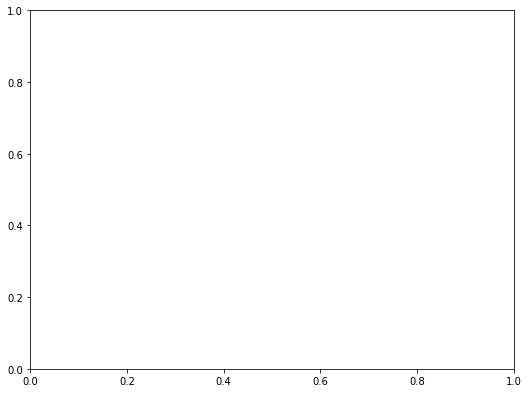

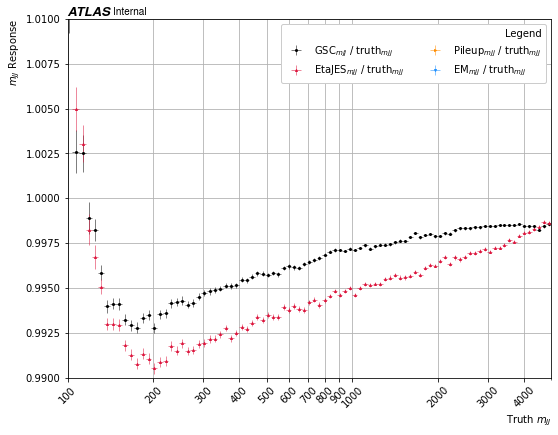

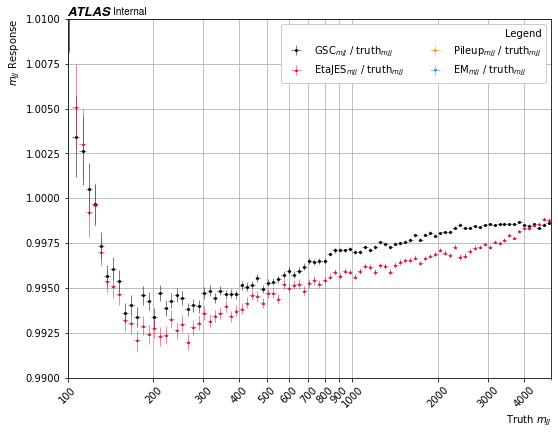

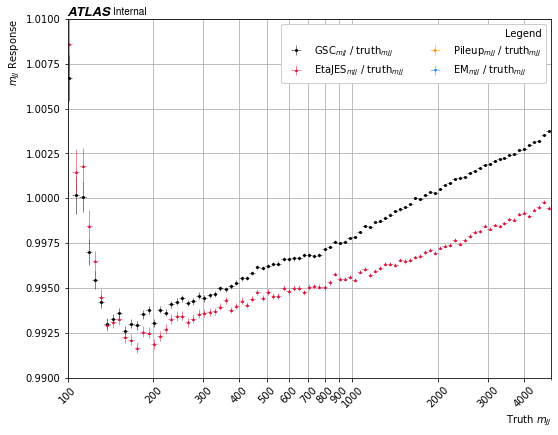

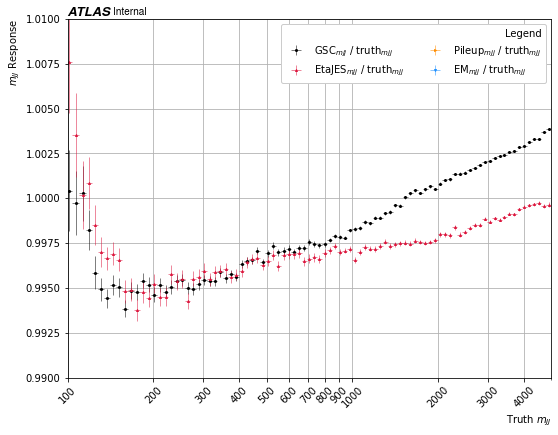

In [ ]:
# Get data information based on root file path and TH3 name
DataOrMC = isItDataOrMC(rootFilePath)
OnlineOrOffline = isItOnlineOrOffline(rootFilePath)

## Drop unwanted TH3s based on xAxisUnit
#df = pd.read_pickle("./TH3Dataframe.pickle")
#for TH3Name in df.index:
#    if(xAxisUnit not in TH3Name ):
#        df.drop(TH3Name, inplace=True)

# Initialize figure and padding
f, ax = plt.subplots(figsize=(8, 6),sharex=True)
f.subplots_adjust(left=0.11, right=0.95, bottom=0.12, top=0.95)

# Define markers and colors for plots
markers = ["o","^",">","v","<"]
colors = ["black","crimson","darkorange","dodgerblue","forestgreen"]


for rootFilePath in listOfRootFilePaths:
    for currentSlice in slices:
        #plt.cla()
        #plt.clf()
        f, ax = plt.subplots(figsize=(8, 6),sharex=True)
        f.subplots_adjust(left=0.11, right=0.95, bottom=0.12, top=0.95)
        dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
        df = pd.read_pickle(dfPath+".pickle")
        
        # Iterate over TH3s in data frame
        i=-1
        for TH3Name in reversed(df.index):
            skipping = False
            if xAxisUnit not in TH3Name:
                skipping = True
            for skippedEnergyScales in skipEnergyScales:
                if skippedEnergyScales in TH3Name:
                    skipping = True
            if skipping: continue
            i+=1
            print("TH3 Name:",TH3Name,i)

            # Get data information based on TH3 name
            numeratorEnergyScale = TH3Name.split("_-_")[1].split("_")[0].split("-")[0]
            denominatorEnergyScale = TH3Name.split("_-_")[1].split("_")[2].split("-")[0]
            if denominatorEnergyScale == "":denominatorEnergyScale = TH3Name.split("_-_")[1].split("_")[2].split("-")[1]

            # Assign data from dataframe
            x=df["x"].loc[TH3Name]
            y=df["y"].loc[TH3Name]
            x_error=df["xError"].loc[TH3Name]
            y_error=df["yError"].loc[TH3Name]

            # Plot data
            ax.errorbar(x, y, yerr=y_error, xerr=x_error,
                        linestyle='None',
                        marker=markers[i],
                        color=colors[i],
                        markersize=2,
                        linewidth=0.5,
                        label=numeratorEnergyScale+"$_{"+xAxisUnit+"}$"+" / "+denominatorEnergyScale+"$_{"+xAxisUnit+"}$",
                       )

        # Add legend
        leg = ax.legend(borderpad=0.5, loc=1, ncol=2, frameon=True,facecolor="white",framealpha=1)
        leg._legend_box.align = "right"
        leg.set_title(legendTitle)#+"\nFit range:["+str(round(x[0],0))+", "+str(round(x[-1],0))+"] GeV")

        # Set limits and labels
        ax.set_xlim(xLimits)
        ax.set_ylim(yLimits)

        # Set log scale
        ax.set_xscale("log")

        # Set axis labels
        ax.set_xlabel(xAxisLabel, ha='right',x=1.0)
        ax.set_ylabel(yAxisLabel, ha='right', y=1.0)


        # Add grid and custom tick markers
        ax.grid(True)
        tickList = [1,2,3,4,5,6,7,8,9,
        10,20,30,40,50,60,70,80,90,
        100,200,300,400,500,600,700,800,900,
        1000,2000,3000,4000,5000,6000,7000,8000,9000,
        10000]
        ax.set_xticks(tickList[tickList.index(xLimits[0]):tickList.index(xLimits[1])])
        ax.set_xticklabels(tickList[tickList.index(xLimits[0]):tickList.index(xLimits[1])])
        plt.xticks(rotation=45)

        # Add ATLAS label
        hep.atlas.text("Internal",ax=ax)

        f.savefig(dfPath+"_"+xAxisUnit+".pdf")

### Resolution

In [ ]:
listOfPaths = [
                "/home/pekman/TLA/TH3Files/v14/merged_mc16d_mjj_v14.root",
                "/home/pekman/TLA/TH3Files/v19/merged_mc16a_mjj_v19.root",
                ]

f, axisList = plt.subplots(2,1,figsize=(400/60,300/60), dpi=60,sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax=axisList[0]

color_list=["black","grey"]

linspace=np.linspace(x[0],x[-1],num=10000)

def resolutionFunc(x,a,b,c):
    return np.sqrt((a/np.sqrt(x))**2+(b/x)**2+c**2)


for i,path in enumerate(listOfPaths):
    # Get data information based on root file path and TH3 name
    DataOrMC = isItDataOrMC(rootFilePath)
    OnlineOrOffline = isItOnlineOrOffline(rootFilePath)
    print(DataOrMC,OnlineOrOffline)
    continue
    
    # Assign data from dataframe
    x=df["x"].loc[TH3Name]
    y=df["sigmaOverY"].loc[TH3Name]
    x_error=df["xError"].loc[TH3Name]
    y_error=df["sigmaOverYError"].loc[TH3Name]
    
    ax.errorbar(x, y, yerr=y_error, xerr=x_error,
                linestyle='None',
                marker="o",
                color=color_list[i],
                markersize=marker_size,
                linewidth=0.5,
                label=path.split("/")[-1].split("_")[1]+OnlineOrOffline)

    popt_resolutionFunc, pcov_resolutionFunc = curve_fit(resolutionFunc, x, y, sigma=y_error)

    
    ax.plot(linspace, resolutionFunc(linspace,*popt_resolutionFunc), lw=1, label=path.split("/")[-1].split("_")[1]+OnlineOrOffline+" Fit",color=color_list[i])

ax.plot(linspace[240:], resolutionFunc(linspace[240:],0.27,10.6,0.039), lw=1, label=r'2016 Online Fit',color="blue")
ax.plot(linspace[:240], resolutionFunc(linspace[:240],0.27,10.6,0.039), lw=1, label=r'2016 Extrapolated Fit',color="blue",linestyle='dashed')


# Legend
leg = ax.legend(borderpad=0.5, frameon=True, loc=1,ncol=2,facecolor="white",framealpha=1.0)
leg._legend_box.align = "right"

#ax.set_xlabel(r"Truth $m_{jj}$ [GeV]", ha='right', x=1.0)
ax.set_ylabel(r'$m_{jj}$ Resolution', ha='right', y=1.0)
#leg.set_title("Online small-R jets: "+"$\eta$ = "+str(currentSlice)+", $y^{*}<0.6$")#+"\nFit range:["+str(round(x[0],0))+", "+str(round(x[-1],0))+"] GeV")
leg.set_title("Online vs. Offline Resolution")
hep.atlas.text("Simulation Internal",ax=ax)

ax.set_xlim(100,5000)
#ax1.set_ylim(pp["scaleDict"][TH3Name]["yMin"],pp["scaleDict"][TH3Name]["yMax"])
ax.set_xscale("log")
ax.set_ylim(0.02,0.2)

ax.grid()

ax=axisList[1]

ax.errorbar(x_list[0], y_list[0]/y_list[1],
            linestyle='None',
            marker="o",
            color="black",
            markersize=marker_size,
            linewidth=0.5,
            label=my_label)

ax.set_xlim(100,5000)
ax.set_ylim(0.98,1.12)
ax.plot( [100,5000], [1.0,1.0],color="red",lw=1)
ax.plot( [100,5000], [1.1,1.1],color="red",lw=1)

#plt.xticks(rotation=45)
ax.set_axisbelow(True)
ax.set_xticks([100,400,1000,5000])
ax.set_xticklabels([100,400,1000,5000])
leg2 = ax.legend(borderpad=0.5, frameon=True, loc=1,ncol=2,facecolor="white",framealpha=1.0)
leg2._legend_box.align = "right"

ax.set_xlabel(r"Truth $m_{jj}$ [GeV]", ha='right', x=1.0)
ax.set_ylabel(r'$m_{jj}$ Resolution Ratio', ha='right', y=1.0)
leg2.set_title("Resolution ratio mc16d/mc16a")

plt.tight_layout()

f.savefig("comparison_mc16d.pdf")

#### Resolution Based Binning

In [ ]:
if(my_label=="mc16d Online"):
    currentEdge = 531
    bins1 = [currentEdge]
    while (currentEdge > 100):
        currentBinwidth = int(round( resolutionFunc(currentEdge, *popt_resolutionFunc)*currentEdge ))
        currentEdge -= currentBinwidth
        bins1.append(currentEdge)
    bins1=bins1[1:]

    currentEdge = 531
    bins2 = [currentEdge]
    while (currentEdge < 5000):
        currentBinwidth = int(round( resolutionFunc(currentEdge, *popt_resolutionFunc)*currentEdge ))
        currentEdge += currentBinwidth
        bins2.append(currentEdge)
    bins=bins1+bins2
    bins.sort()
    print(bins)

    #Create JSON and ROOT binning
    mjjBins = {
        'TLAdefault':   bins,
        'TLAlowMu'  :   []
    }

    outfile = open('mjjBins.json','w')
    outfile.write(json.dumps(mjjBins, sort_keys=True, indent=4, separators=(',', ': ')))
    outfile.close()

    rootfile = ROOT.TFile('mjjBins.root', 'recreate')
    mjjBins = json.load(open('mjjBins.json'))
    hists = {}
    for key in mjjBins:
        if len(mjjBins[key])-1 < 1:
            continue
        hists[key] = ROOT.TH1F('h_'+key, ';mjj;', len(mjjBins[key])-1, array('d',mjjBins[key]))
        hists[key].Write()
    rootfile.Close()

    #Check if JSON and root binning is the same
    inJSON = open('mjjBins.json','r')
    JSONBinDict = json.load(inJSON)
    inROOT = ROOT.TFile('mjjBins.root', 'read')
    listOfROOTBins = []

    listOfKeys2 = inROOT.GetListOfKeys()
    for key in listOfKeys2:
        h1Name = key.GetName()
        h1 = inROOT.Get(h1Name)
        for j in range(1, h1.GetNbinsX()+2):
                assert (h1.GetBinLowEdge(j) == JSONBinDict[str(key).split(" ")[1][2:]][j-1])